# Netflix study

In [2]:
import pandas as pd

netflix_df = pd.read_csv(r'netflix_titles.csv')

## opg 1.1. Find det gns antal skuespillere per film/tv-show.


In [244]:
netflix_df['cast2'] = netflix_df.cast.str.split(pat=",")

print('Antal film/serier:', len(netflix_df))
print()

netflix_df.cast2.str.len() # antal skuespillere pr film


print('Samlet antal ikke-NaN-skuespillere:', netflix_df.cast2.str.len().sum(skipna=True))
print()

print('Gns. antal ikke-NaN-skuespillere pr. udgivelse:', round(64126/8807))
print()

print('Gns. antal skuespillere pr. udgivelse, eksl. NaN:', round(netflix_df.cast2.str.len().mean())) # eksl NaN

Antal film/serier: 8807

Samlet antal ikke-NaN-skuespillere: 64126.0

Gns. antal ikke-NaN-skuespillere pr. udgivelse: 7

Gns. antal skuespillere pr. udgivelse, eksl. NaN: 8


## opg. 1.2. Find det gennemsnitlige antal film/tv-shows per skuespiller.

In [64]:
netflix_df2 = netflix_df[['cast2']]

netflix_df2.cast2.sort_values()

print('Gns. antal film/shows pr. skuespiller:', round(netflix_df2.explode(column='cast2').value_counts().mean(), ndigits=1))
print()

print('Gns. antal film/shows pr. skuespiller, cleaner', round(netflix_df2.explode(column='cast2')['cast2'].str.lstrip().value_counts().mean(), ndigits=1)) # without leading characters like newlines, whitespace, numbers, dots, etc.



Gns. antal film/shows pr. skuespiller: 1.6

Gns. antal film/shows pr. skuespiller, cleaner 1.8


## opg. 2. Lav et histogram for antal film/tv-shows per instruktør.

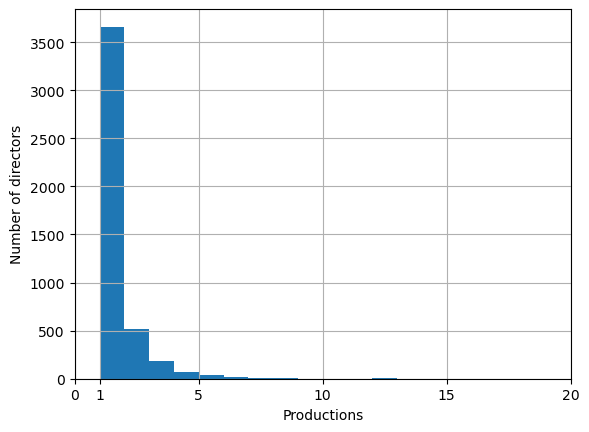

In [134]:
from matplotlib import pyplot as plt

directors = netflix_df['director']

#directors.value_counts().hist(legend=True)

directors.value_counts().hist(bins=18).set_xticks([0,1,5,10,15,20])
plt.ylabel('Number of directors')
plt.xlabel('Productions')
plt.show()

## opg. 3. Beskriv hvad du synes er et andet interessant aspekt af datasættet statistisk (f.eks. min, max, gennemsnit, varians) og visuelt (f.eks. histogrammer og tidslinjer).

In [281]:
country_df = netflix_df['country'].to_frame()

country_df['country'] = country_df['country'].apply(lambda x_row: x_row.split(', ') if isinstance(x_row, str) else x_row)

country_df = country_df.explode('country').reset_index(drop=True) # no lrstrip() needed

prod_pr_country = country_df.value_counts().rename_axis('countries').reset_index(name='productions')

print(round(prod_pr_country.productions.describe()))

count     127.0
mean       79.0
std       350.0
min         1.0
25%         1.0
50%         5.0
75%        38.0
max      3689.0
Name: productions, dtype: float64


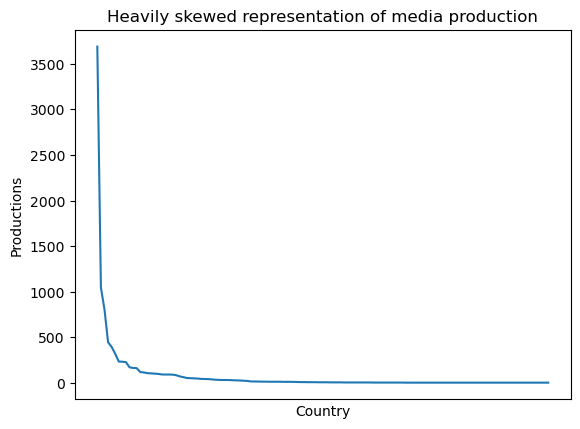

In [276]:

prod_pr_country.plot(legend=False, title='Heavily skewed representation of media production')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Productions')
plt.xlabel('Country')
plt.show()


Der er ca. 20 gange så mange us prod som ch prod

        countries  productions
0   United States         3689
10          China          162


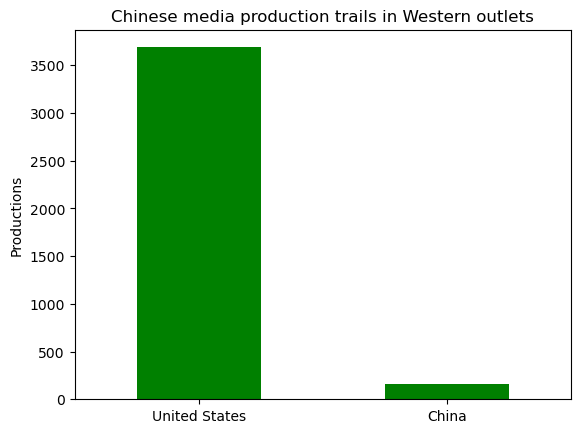

In [278]:
us_china = prod_pr_country.loc[prod_pr_country['countries'].isin(['United States','China'])]

print('Der er ca. 20 gange så mange us prod som ch prod')
print()

print(us_china)

us_china.plot(kind='bar', color='green', ylabel='Productions', x='countries', rot=0, legend=False, title='Chinese media production trails in Western outlets',xlabel='')
plt.show()

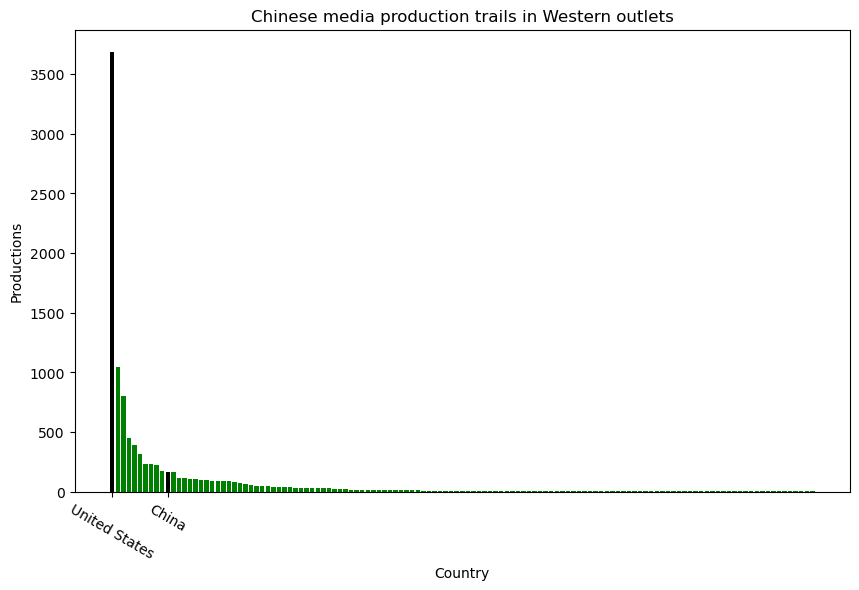

0     3689
10     162
Name: productions, dtype: int64

0     United States
10            China
Name: countries, dtype: object


In [312]:
#print(prod_pr_country)

# Plot the distribution of productions for all countries
plt.figure(figsize=(10, 6))
plt.bar(prod_pr_country['countries'], prod_pr_country['productions'], label='All Countries', color='green')

highlight_countries = ['United States', 'China']
highlight_values = prod_pr_country[prod_pr_country['countries'].isin(highlight_countries)]['productions']
highlight_labels = prod_pr_country[prod_pr_country['countries'].isin(highlight_countries)]['countries']
plt.bar(highlight_labels, highlight_values, color='black', label='Highlighted Countries')
plt.xlabel('Country')
plt.ylabel('Productions')
plt.title('Chinese media production trails in Western outlets')
plt.xticks(highlight_labels, rotation = -30)
plt.show()

print(prod_pr_country[prod_pr_country['countries'].isin(highlight_countries)]['productions'])
print()
print(prod_pr_country[prod_pr_country['countries'].isin(highlight_countries)]['countries'])

count    8807.0
mean     2014.0
std         9.0
min      1925.0
25%      2013.0
50%      2017.0
75%      2019.0
max      2021.0
Name: release_year, dtype: float64


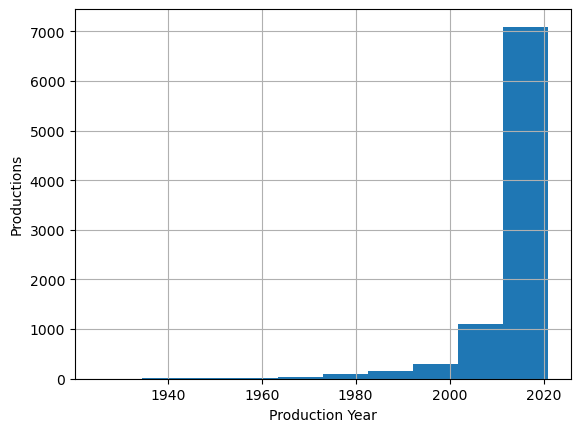

In [308]:
print(round(netflix_df.release_year.describe())) # det er film der går tilbage til 1925 fra 2021

netflix_df.release_year.hist()
plt.ylabel('Productions')
plt.xlabel('Production Year')
plt.show()

Graph with 38743 nodes and 291480 edges


/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 12539 missing from current font.

/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning:

Glyph 12539 missing from current font.



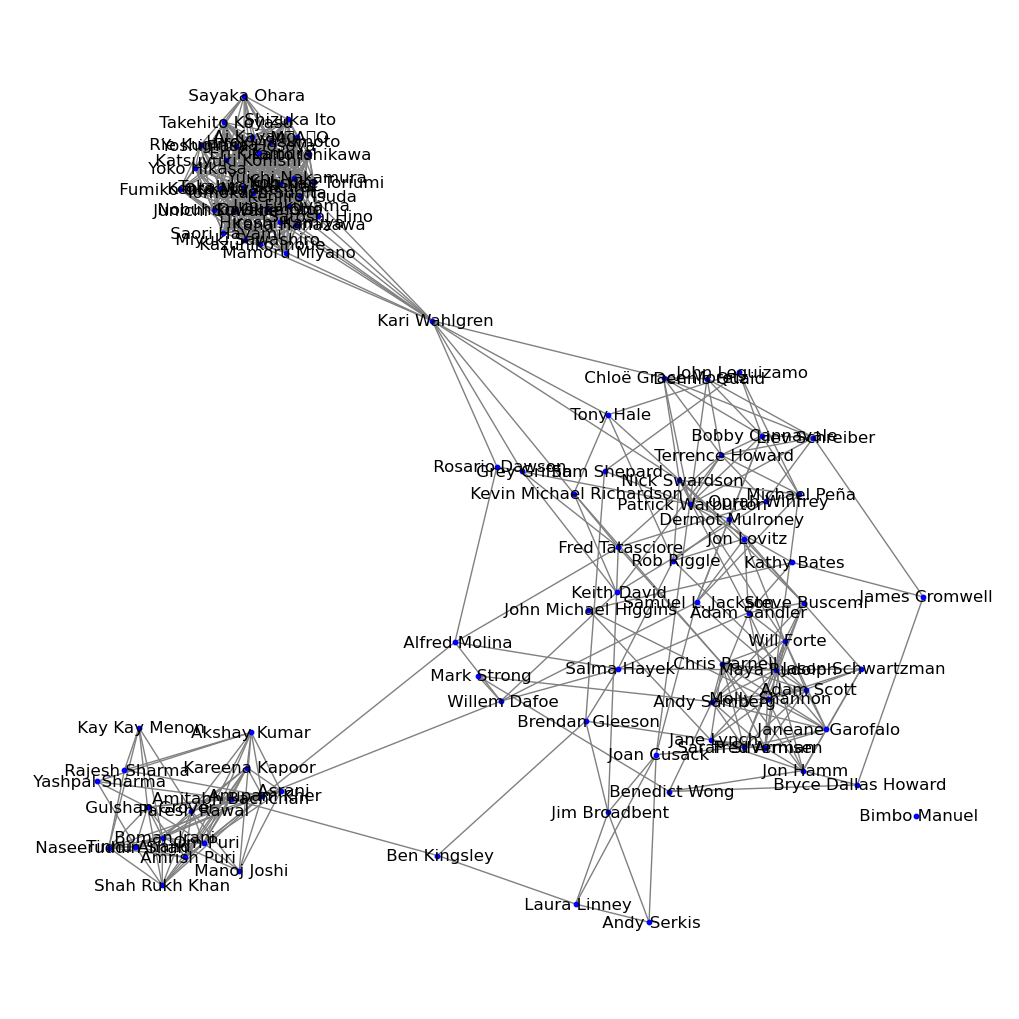

In [387]:
import networkx as nx
from itertools import combinations

casts = netflix_df.dropna(subset=['cast2'])

G = nx.Graph()

for contributors in casts['cast2']:
    G.add_edges_from(combinations(contributors, 2))

print(G)

node_degrees = dict(G.degree())

top_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:100] # top 100

G_top = G.subgraph(top_nodes)

pos = nx.spring_layout(G_top, k=.35)

plt.figure(figsize=(10, 10))
nx.draw(G_top, pos, with_labels=True, node_color='blue', node_size=10, edge_color='grey')
plt.show()


In [385]:
import plotly.graph_objects as go

# https://stackoverflow.com/questions/65752590/converting-a-networkx-2d-graph-into-a-3d-interactive-graph
Num_nodes = len(G_top.nodes)

edges = G_top.edges()

spring_3D = nx.spring_layout(G_top, dim = 3, k = 0.35)

x_nodes = [spring_3D[key][0] for key in spring_3D.keys()] # x-coordinates of nodes
y_nodes = [spring_3D[key][1] for key in spring_3D.keys()] # y-coordinates
z_nodes = [spring_3D[key][2] for key in spring_3D.keys()] # z-coordinates

x_edges=[]
y_edges=[]
z_edges=[]

xtp = []
ytp = []
ztp = []

for edge in edges:
    #format: [beginning,ending,None]
    x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
    x_edges += x_coords
    xtp.append(0.5*(spring_3D[edge[0]][0]+ spring_3D[edge[1]][0]))

    y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
    y_edges += y_coords
    ytp.append(0.5*(spring_3D[edge[0]][1]+ spring_3D[edge[1]][1]))

    z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
    z_edges += z_coords
    ztp.append(0.5*(spring_3D[edge[0]][2]+ spring_3D[edge[1]][2])) 


#create a trace for the edges
trace_edges = go.Scatter3d(
    x=x_edges,
    y=y_edges,
    z=z_edges,
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none')

#create a trace for the nodes
trace_nodes = go.Scatter3d(
    x=x_nodes,
    y=y_nodes,
    z=z_nodes,
    mode='markers',
    marker=dict(symbol='circle',
            size=10,
            color='skyblue')
    )

#Include the traces we want to plot and create a figure
data = [trace_edges, trace_nodes]
fig = go.Figure(data=data)

fig.show()

In [ ]:
###### weights



# G2 = nx.Graph()

# for contributors in casts['cast2']:
#     actor_pairs = combinations(contributors, 2)
#     for actor_pair in actor_pairs:
#         actor1, actor2 = actor_pair
#         if G2.has_edge(actor1, actor2):
#             G2[actor1][actor2]['weight'] += 1
#         else:
#             G2.add_edge(actor1, actor2, weight=1)

# print(G2)

## opg. 4. Hvordan kan vi estimere de mest sete film/tv-shows, uden at have adgang til yderligere Netflix-data? Er der offentligt tilgængelige data, der kan hjælpe os med denne vurdering?

- de meste sete af hvem og hvor henne?
- ...
- ~20% (1.700 mia. / 8 mia.) af jordens befolkning bruger ikke nødvendigvis de samme tjenester eller kanaler. Visse lande censurere fx imdb.
- for at beskrive de meste sete film og tv-shows på verdensplan skal man bruge andre data, som ikke alle nødvendigvis er offentligt tilgængelige.
- ...
- ser man bort fra det kan man lægge til grund at netflix's udbud afspejler efterspørgslen. Ved at gruppere efter hyppigste instruktører, skuespillere, produktionsland, år, rating, duration, osv, kan man finde frem til typetallet (engelsk: mode); dvs. værdier med højest frekvens.
- alternativet er at diskutere forskellige kilders fordele og ulemper. Data vedr. antal seere er mest valide.

In [388]:
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cast2
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[Ama Qamata, Khosi Ngema, Gail Mabalane, Th..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, ..."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,"[Mayur More, Jitendra Kumar, Ranjan Raj, Al..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...","[Mark Ruffalo, Jake Gyllenhaal, Robert Downe..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",NaN
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,"[Jesse Eisenberg, Woody Harrelson, Emma Ston..."
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...","[Tim Allen, Courteney Cox, Chevy Chase, Kat..."
